In [1]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, StackingClassifier
from sklearn.model_selection import GridSearchCV
import numpy as np
from sklearn.metrics import classification_report
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import TimeSeriesSplit
import re

SEASON_SPLIT = 2024

In [ ]:
matches = pd.read_csv('matches.csv', index_col=0)
print(matches.shape)

(2320, 28)


In [ ]:
LEAGUE = 'Premier Legaue'
league_matches = matches[matches['Comp'] == LEAGUE]

In [3]:
matches['Team'].value_counts()

Team
Arsenal                     116
Tottenham Hotspur           116
Liverpool                   116
Chelsea                     116
Nottingham Forest           116
Manchester City             116
Everton                     116
Bournemouth                 116
Brentford                   116
West Ham United             116
Fulham                      116
Newcastle United            116
Crystal Palace              116
Manchester United           116
Aston Villa                 116
Wolverhampton Wanderers     116
Brighton and Hove Albion    116
Southampton                  76
Leicester City               76
Burnley                      40
Leeds United                 40
Luton Town                   38
Ipswich Town                 38
Sheffield United             38
Sunderland                    2
Name: count, dtype: int64

In [4]:
matches['Opponent'].value_counts()

Opponent
Manchester Utd     116
Bournemouth        116
Manchester City    116
Crystal Palace     116
Newcastle Utd      116
West Ham           116
Brentford          116
Tottenham          116
Wolves             116
Fulham             116
Chelsea            116
Brighton           116
Liverpool          116
Nott'ham Forest    116
Aston Villa        116
Everton            116
Arsenal            116
Leicester City      76
Southampton         76
Burnley             40
Leeds United        40
Sheffield Utd       38
Ipswich Town        38
Luton Town          38
Sunderland           2
Name: count, dtype: int64

In [5]:
matches.dtypes

Date              object
Time              object
Comp              object
Round             object
Day               object
Venue             object
Result            object
GF                 int64
GA                 int64
Opponent          object
xG               float64
xGA              float64
Poss             float64
Attendance       float64
Captain           object
Formation         object
Opp Formation     object
Referee           object
Match Report      object
Notes            float64
Sh               float64
SoT              float64
Dist             float64
FK               float64
PK                 int64
PKatt              int64
Season             int64
Team              object
dtype: object

In [6]:
team_names = sorted(matches['Team'].unique())
opp_names = sorted(matches['Opponent'].unique())

exculsive_team_names = []
exculsive_opp_names = []

for i in team_names:
    if (i not in opp_names):
        exculsive_team_names.append(i)
        print(i)

print('---------------------------')

for i in opp_names:
    if (i not in team_names):
        exculsive_opp_names.append(i)
        print(i)

Brighton and Hove Albion
Manchester United
Newcastle United
Nottingham Forest
Sheffield United
Tottenham Hotspur
West Ham United
Wolverhampton Wanderers
---------------------------
Brighton
Manchester Utd
Newcastle Utd
Nott'ham Forest
Sheffield Utd
Tottenham
West Ham
Wolves


In [7]:
class MissingDict(dict):
    __missing__ = lambda self, key: key

map_values = {}

for team_name, opp_name in zip(exculsive_team_names, exculsive_opp_names):
    map_values[team_name] = opp_name

mapping = MissingDict(**map_values)

In [8]:
matches.head()

,Date,Time,Comp,Round,Day,Venue,Result,GF,GA,Opponent,...,Match Report,Notes,Sh,SoT,Dist,FK,PK,PKatt,Season,Team
0,2025-08-17,16:30 (01:30),Premier League,Matchweek 1,Sun,Away,W,1,0,Manchester Utd,...,Match Report,NaN,9.0,3.0,18.6,1.0,0,0,2026,Arsenal
1,2025-08-23,17:30 (02:30),Premier League,Matchweek 2,Sat,Home,W,5,0,Leeds United,...,Match Report,NaN,17.0,4.0,15.2,0.0,1,1,2026,Arsenal
1,2025-08-16,15:00 (00:00),Premier League,Matchweek 1,Sat,Home,W,3,0,Burnley,...,Match Report,NaN,16.0,6.0,13.7,0.0,0,0,2026,Tottenham Hotspur
2,2025-08-23,12:30 (21:30),Premier League,Matchweek 2,Sat,Away,W,2,0,Manchester City,...,Match Report,NaN,12.0,5.0,14.5,1.0,0,0,2026,Tottenham Hotspur
1,2025-08-15,20:00 (05:00),Premier League,Matchweek 1,Fri,Home,W,4,2,Bournemouth,...,Match Report,NaN,19.0,10.0,16.6,0.0,0,0,2026,Liverpool


In [9]:
matches['Team'] = matches['Team'].map(mapping)
team_mapping_dict = {key: value for key, value in zip(matches['Team'], matches['Team'].astype('category').cat.codes)}
matches['Team_code'] = matches['Team'].map(team_mapping_dict)
matches['Opp_code'] = matches['Opponent'].map(team_mapping_dict)

matches['Date'] = pd.to_datetime(matches['Date'])
matches['Venue_code'] = matches['Venue'].astype('category').cat.codes
matches['Hour'] = matches['Time'].str.replace(":.+", "", regex=True).astype('int')
matches['Day_code'] = matches['Date'].dt.dayofweek

formation_mapping_dict = {key: value for key, value in zip(matches['Formation'], matches['Formation'].astype('category').cat.codes)}
formation_mapping_dict.update({key: value for key, value in zip(matches['Opp Formation'], matches['Opp Formation'].astype('category').cat.codes)})

matches['Formation_code'] = matches['Formation'].map(formation_mapping_dict)
matches['Opp_formation_code'] = matches['Opp Formation'].map(formation_mapping_dict)

matches['Target'] = matches['Result'].astype('category').cat.codes

sorted_round = sorted(matches['Round'].unique(), key=lambda round:int((re.search('[0-9]+$', round)).group(0)))
round_mapping_dict = {value: key for key, value in enumerate(sorted_round, start=1)}
matches['Round'] = matches['Round'].map(round_mapping_dict)

In [10]:
matches['Target'].value_counts()

Target
2    893
1    893
0    534
Name: count, dtype: int64

In [11]:
def rolling_avgs(group, cols, new_cols):
    group = group.sort_values('Date')
    rolling_stats = group[cols].rolling(3, closed='left', min_periods=1).mean()
    group[new_cols] = rolling_stats.fillna(0)
    return group

In [12]:
ravg_cols = ['GF', 'GA', 'Sh', 'SoT', 'Dist', 'FK', 'PK', 'PKatt']
ravg_new_cols = [f"{c}rolling" for c in ravg_cols]

In [13]:
team_matches = matches.groupby('Team', group_keys=True).apply(lambda x: rolling_avgs(x, ravg_cols, ravg_new_cols), include_groups=False).reset_index(level=0).reset_index(drop=True)
# team_matches = team_matches.droplevel('Team')
# team_matches.index = range(team_matches.shape[0])
team_matches

,Team,Date,Time,Comp,Round,Day,Venue,Result,GF,GA,...,Opp_formation_code,Target,GFrolling,GArolling,Shrolling,SoTrolling,Distrolling,FKrolling,PKrolling,PKattrolling
0,Arsenal,2022-08-05,20:00 (05:00),Premier League,1,Fri,Away,W,2,0,...,10,2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0
1,Arsenal,2022-08-13,15:00 (00:00),Premier League,2,Sat,Home,W,4,2,...,5,2,2.000000,0.000000,10.000000,2.000000,14.600000,1.000000,0.0,0.0
2,Arsenal,2022-08-20,17:30 (02:30),Premier League,3,Sat,Away,W,3,0,...,0,2,3.000000,1.000000,14.500000,4.500000,13.800000,0.500000,0.0,0.0
3,Arsenal,2022-08-27,17:30 (02:30),Premier League,4,Sat,Home,W,2,1,...,10,2,3.000000,0.666667,14.333333,5.000000,14.133333,0.333333,0.0,0.0
4,Arsenal,2022-08-31,19:30 (04:30),Premier League,5,Wed,Home,W,2,1,...,14,2,3.000000,1.000000,18.333333,7.000000,14.433333,0.333333,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2315,Wolves,2025-05-10,15:00 (00:00),Premier League,36,Sat,Home,L,0,2,...,10,1,1.333333,0.333333,10.000000,2.333333,18.900000,0.666667,0.0,0.0
2316,Wolves,2025-05-20,20:00 (05:00),Premier League,37,Tue,Away,L,2,4,...,4,1,1.000000,1.000000,12.000000,2.666667,17.200000,0.333333,0.0,0.0
2317,Wolves,2025-05-25,16:00 (01:00),Premier League,38,Sun,Home,D,1,1,...,10,0,0.666667,2.333333,9.333333,2.000000,15.633333,0.000000,0.0,0.0
2318,Wolves,2025-08-16,17:30 (02:30),Premier League,1,Sat,Home,L,0,4,...,14,1,1.000000,2.333333,13.333333,4.000000,17.066667,0.000000,0.0,0.0


In [14]:
# add ranking of the teams at each match
from collections import defaultdict

team_matches = team_matches.sort_values('Date').reset_index(drop=True)

curr_season = 0
for season_gameweek, stats in team_matches.groupby(['Season', 'Round'], sort=True):
    if curr_season != season_gameweek[0]:
        curr_season = season_gameweek[0]
        standings = defaultdict(lambda : {'points': 0, 'goal_diff': 0, 'GF': 0})

    sorted_standings = sorted(standings.items(), 
                              key=lambda x: (-x[1]['points'], -x[1]['goal_diff'], -x[1]['GF'], x[0]))
    ranking = {team: pos for pos, (team, stats) in enumerate(sorted_standings, start=1)}
    
    # setting current league position
    for index, row in stats.iterrows():
        team_matches.at[index, 'Team_position'] = ranking.get(row['Team'], 0)
        team_matches.at[index, 'Opp_position'] = ranking.get(row['Opponent'], 0)

    # updating ranking data
    for index, row in stats.iterrows():
        goals_for = row['GF']
        goals_against = row['GA']
        standings[row['Team']]['GF'] += goals_for
        standings[row['Team']]['goal_diff'] += goals_for - goals_against
        
        if goals_for > goals_against:
            standings[row['Team']]['points'] += 3
        elif goals_for < goals_against:
            standings[row['Team']]['points'] += 0
        else:
            standings[row['Team']]['points'] += 1

team_matches

,Team,Date,Time,Comp,Round,Day,Venue,Result,GF,GA,...,GFrolling,GArolling,Shrolling,SoTrolling,Distrolling,FKrolling,PKrolling,PKattrolling,Team_position,Opp_position
0,Arsenal,2022-08-05,20:00 (05:00),Premier League,1,Fri,Away,W,2,0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
1,Crystal Palace,2022-08-05,20:00 (05:00),Premier League,1,Fri,Home,L,0,2,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
2,Nott'ham Forest,2022-08-06,15:00 (00:00),Premier League,1,Sat,Away,L,0,2,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
3,Fulham,2022-08-06,12:30 (21:30),Premier League,1,Sat,Home,D,2,2,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
4,Wolves,2022-08-06,15:00 (00:00),Premier League,1,Sat,Away,L,1,2,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2315,Nott'ham Forest,2025-08-24,14:00 (23:00),Premier League,2,Sun,Away,D,1,1,...,1.666667,1.000000,10.333333,4.000000,15.833333,0.333333,0.0,0.0,5.0,12.0
2316,Everton,2025-08-24,14:00 (23:00),Premier League,2,Sun,Home,W,2,0,...,1.000000,0.333333,11.333333,3.666667,15.033333,0.666667,0.0,0.0,14.0,8.0
2317,Crystal Palace,2025-08-24,14:00 (23:00),Premier League,2,Sun,Home,D,1,1,...,1.666667,1.000000,11.000000,6.333333,20.033333,0.333333,0.0,0.0,12.0,5.0
2318,Newcastle Utd,2025-08-25,20:00 (05:00),Premier League,2,Mon,Home,L,2,3,...,0.000000,0.666667,15.666667,4.666667,18.466667,0.666667,0.0,0.0,13.0,4.0


In [15]:
team_matches = team_matches.drop(columns=['Time', 'Team', 'Venue', 'Opponent', 'Comp', 'Round', 'Day', 'Result', 'Attendance', 
                                            'Captain', 'Referee', 'Match Report', 'Notes', 'Formation', 'Opp Formation'])

In [16]:
team_matches.isnull().value_counts()

Date   GF     GA     xG     xGA    Poss   Sh     SoT    Dist   FK     PK     PKatt  Season  Team_code  Opp_code  Venue_code  Hour   Day_code  Formation_code  Opp_formation_code  Target  GFrolling  GArolling  Shrolling  SoTrolling  Distrolling  FKrolling  PKrolling  PKattrolling  Team_position  Opp_position
False  False  False  False  False  False  False  False  False  False  False  False  False   False      False     False       False  False     False           False               False   False      False      False      False       False        False      False      False         False          False           2320
Name: count, dtype: int64

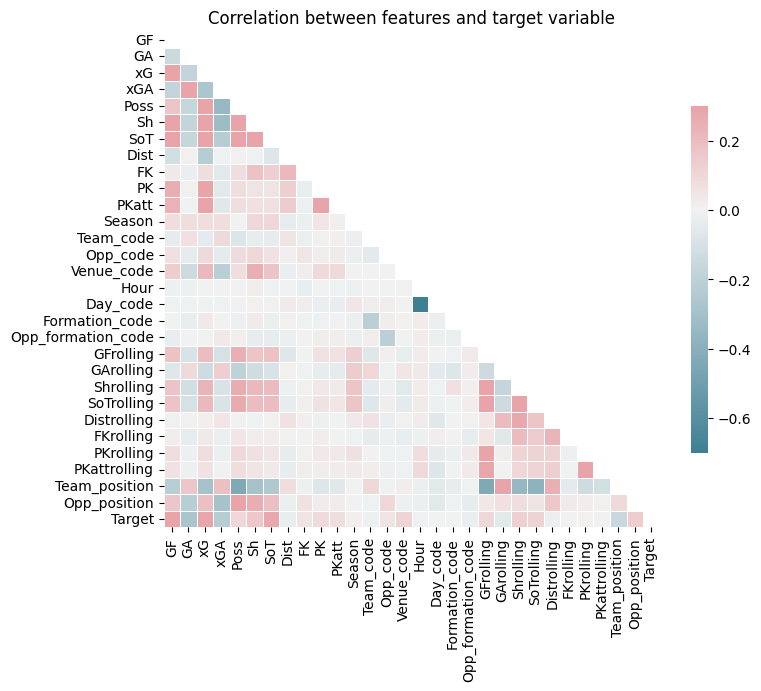

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt
train = team_matches[team_matches['Season'] <= SEASON_SPLIT]
data = pd.concat([train.drop(columns=['Date', 'Target']), train['Target']], axis=1)

corr_mat = data.corr()                               # compute the correlation matrix

mask = np.zeros_like(corr_mat, dtype=bool)            # mask out upper triangle (correlation matrices are symmetric)
mask[np.triu_indices_from(mask)] = True


f, ax = plt.subplots(figsize=(8, 9))
cmap = sns.diverging_palette(220, 10, as_cmap=True)   # generate custom colormap
sns.heatmap(corr_mat, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.title('Correlation between features and target variable')
plt.show()

In [18]:
def calculate_weight(date, min, max):
    return (date - min) / (max - min)

min_date = min(team_matches['Date'])
max_date = max(team_matches['Date'])

# sample_weights = np.array([calculate_weight(year, min_year, max_year) for year in team_matches['Season']])

# weights_sum = sample_weights.sum()
# normalized_sample_weights = sample_weights / weights_sum
# normalized_sample_weights.shape

predictors = ['Team_code', 'Venue_code', 'Opp_code', 'Hour', 'Day_code', 'xG',
              'xGA', 'Team_position', 'Opp_position']
# train_sample_weights = []

# for index, sample_weight in enumerate(normalized_sample_weights):
#     if team_matches.iloc[index]['Date'] < pd.to_datetime('2024-08-16'):
#         train_sample_weights.append(sample_weight)
        
train = team_matches[team_matches['Season'] <= SEASON_SPLIT]
test = team_matches[team_matches['Season'] > SEASON_SPLIT]
train_X = train[predictors + ravg_new_cols]
test_X = test[predictors + ravg_new_cols]

# sample_weights = np.array([calculate_weight(date, min_date, max_date) for date in train['Date']])

# weights_sum = sample_weights.sum()
# normalized_sample_weights = sample_weights / weights_sum

rf_model = RandomForestClassifier(random_state=42)
param_grid = {
    'n_estimators': np.arange(100, 200, 5), 
    'min_samples_split': np.arange(2,10)
}

tscv = TimeSeriesSplit(n_splits=5)

clf = GridSearchCV(estimator=rf_model, param_grid=param_grid, scoring='accuracy', n_jobs=-1, cv=tscv)
clf.fit(train_X, train['Target'])
refined_rf_model = clf.best_estimator_
preds = refined_rf_model.predict(test_X)
print(clf.best_params_)
print(classification_report(test['Target'], preds))

{'min_samples_split': np.int64(6), 'n_estimators': np.int64(145)}
              precision    recall  f1-score   support

           0       0.39      0.05      0.08       196
           1       0.59      0.76      0.67       302
           2       0.59      0.76      0.67       302

    accuracy                           0.59       800
   macro avg       0.53      0.52      0.47       800
weighted avg       0.54      0.59      0.52       800



In [41]:
refined_rf_model.feature_importances_

array([0.05452747, 0.01769058, 0.05934256, 0.03061877, 0.02432312,
       0.1501112 , 0.164387  , 0.06809381, 0.07723131, 0.04997705,
       0.04516421, 0.0725409 , 0.0581901 , 0.07419175, 0.02678379,
       0.01187816, 0.01494821])

In [44]:
predictors + ravg_new_cols

['Team_code',
 'Venue_code',
 'Opp_code',
 'Hour',
 'Day_code',
 'xG',
 'xGA',
 'Team_position',
 'Opp_position',
 'GFrolling',
 'GArolling',
 'Shrolling',
 'SoTrolling',
 'Distrolling',
 'FKrolling',
 'PKrolling',
 'PKattrolling']

In [19]:
xgboost_model = XGBClassifier(random_state=42)
param_grid = {
    'eta': np.arange(0, 1, 0.1), 
    'max_depth': np.arange(1, 10),
    'alpha': np.arange(0, 10)
}

xgboost_clf = GridSearchCV(estimator=xgboost_model, param_grid=param_grid, scoring='accuracy', n_jobs=-1, cv=tscv)
xgboost_clf.fit(train_X, train['Target'])
refined_xgboost_model = xgboost_clf.best_estimator_
xgboost_preds = refined_xgboost_model.predict(test_X)
print(xgboost_clf.best_params_)
print(classification_report(test['Target'], xgboost_preds, zero_division=0))

{'alpha': np.int64(5), 'eta': np.float64(0.2), 'max_depth': np.int64(1)}
              precision    recall  f1-score   support

           0       0.22      0.01      0.02       196
           1       0.60      0.79      0.68       302
           2       0.60      0.78      0.68       302

    accuracy                           0.59       800
   macro avg       0.47      0.53      0.46       800
weighted avg       0.51      0.59      0.52       800



In [20]:
from sklearn.svm import SVC

svc_model = SVC(random_state=42, kernel='rbf')
param_grid = {
    'C': np.arange(0.1, 1, 0.1), 
    'gamma': ['scale','auto']
}

svc_clf = GridSearchCV(estimator=svc_model, param_grid=param_grid, scoring='accuracy', n_jobs=-1, cv=tscv)
svc_clf.fit(train_X, train['Target'])
refined_svc_model = svc_clf.best_estimator_
svc_preds = refined_svc_model.predict(test_X)
print(svc_clf.best_params_)
print(classification_report(test['Target'], svc_preds, zero_division=0))

{'C': np.float64(0.7000000000000001), 'gamma': 'scale'}
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       196
           1       0.56      0.74      0.64       302
           2       0.56      0.74      0.63       302

    accuracy                           0.56       800
   macro avg       0.37      0.49      0.42       800
weighted avg       0.42      0.56      0.48       800



In [21]:
lr_model = LogisticRegression(random_state=42, max_iter=2000)
param_grid = {
    'C': np.arange(0.1, 1, 0.1), 
    'solver': ['saga', 'lbfgs', 'sag', 'newton-cg', 'newton-cholesky']
}

lr_clf = GridSearchCV(estimator=lr_model, param_grid=param_grid, scoring='accuracy', n_jobs=-1, cv=tscv)
lr_clf.fit(train_X, train['Target'])
refined_lr_model = lr_clf.best_estimator_
lr_preds = refined_lr_model.predict(test_X)
print(lr_clf.best_params_)
print(classification_report(test['Target'], lr_preds, zero_division=0))

{'C': np.float64(0.5), 'solver': 'lbfgs'}
              precision    recall  f1-score   support

           0       0.29      0.01      0.02       196
           1       0.60      0.77      0.67       302
           2       0.58      0.77      0.66       302

    accuracy                           0.59       800
   macro avg       0.49      0.52      0.45       800
weighted avg       0.51      0.59      0.51       800



In [22]:
from xgboost import XGBClassifier
from sklearn.utils.class_weight import compute_sample_weight
normalized_sample_weights = compute_sample_weight('balanced', y=train['Target'])
better_xgboost_model = XGBClassifier(alpha=5, random_state=42, eta=0.2, max_depth=1)
better_xgboost_model.fit(train_X, train['Target'], sample_weight = normalized_sample_weights)
better_xgboost_preds = better_xgboost_model.predict(test_X)
print(classification_report(test['Target'], better_xgboost_preds, zero_division=0))

              precision    recall  f1-score   support

           0       0.30      0.35      0.33       196
           1       0.65      0.62      0.64       302
           2       0.66      0.62      0.64       302

    accuracy                           0.56       800
   macro avg       0.54      0.53      0.53       800
weighted avg       0.57      0.56      0.56       800



In [23]:
better_svc_model = SVC(random_state=42, C=0.7, gamma='scale')
better_svc_model.fit(train_X, train['Target'], sample_weight=normalized_sample_weights)
better_svc_preds = better_svc_model.predict(test_X)
print(classification_report(test['Target'], better_svc_preds, zero_division=0))

              precision    recall  f1-score   support

           0       0.27      0.18      0.22       196
           1       0.58      0.66      0.62       302
           2       0.57      0.62      0.59       302

    accuracy                           0.53       800
   macro avg       0.47      0.49      0.48       800
weighted avg       0.50      0.53      0.51       800



In [24]:
better_lr_model = LogisticRegression(random_state=42, C=0.5, max_iter=2000)
better_lr_model.fit(train_X, train['Target'], sample_weight=normalized_sample_weights)
better_lr_preds = better_lr_model.predict(test_X)
print(classification_report(test['Target'], better_lr_preds, zero_division=0))

              precision    recall  f1-score   support

           0       0.34      0.35      0.35       196
           1       0.67      0.66      0.66       302
           2       0.67      0.67      0.67       302

    accuracy                           0.59       800
   macro avg       0.56      0.56      0.56       800
weighted avg       0.59      0.59      0.59       800



In [25]:
rf_model = RandomForestClassifier(random_state=42, n_estimators=145, min_samples_split=6)

rf_model.fit(train_X, train['Target'], sample_weight = normalized_sample_weights)
preds = rf_model.predict(test_X)
print(classification_report(test['Target'], preds, zero_division=0))

              precision    recall  f1-score   support

           0       0.36      0.09      0.14       196
           1       0.60      0.73      0.66       302
           2       0.59      0.75      0.66       302

    accuracy                           0.58       800
   macro avg       0.52      0.52      0.49       800
weighted avg       0.54      0.58      0.53       800



In [33]:
base_estimators = [
    ('rf', RandomForestClassifier(random_state=42, n_estimators=145, min_samples_split=6)),
    ('xgb', XGBClassifier(alpha=5, random_state=42, eta=0.2, max_depth=1))
    # ('lr', LogisticRegression(random_state=42, C=0.5, max_iter=2000))
]


voter = VotingClassifier(estimators=base_estimators, voting='soft')
# voter.fit(train_X, train['Target'])
# preds = voter.predict(test_X)
# print(classification_report(test['Target'], preds, zero_division=0))

param_grid = {
    'weights': [(w1, w2) for w1 in range(1,5) for w2 in range(1,5)]
}

voting_clf = GridSearchCV(estimator=voter, param_grid=param_grid, scoring='accuracy', n_jobs=-1, cv=tscv)
voting_clf.fit(train_X, train['Target'], sample_weight=normalized_sample_weights)
refined_voting_model = voting_clf.best_estimator_
voter_preds = refined_voting_model.predict(test_X)
print(voting_clf.best_params_)
print(classification_report(test['Target'], voter_preds, zero_division=0))

{'weights': (4, 1)}
              precision    recall  f1-score   support

           0       0.44      0.13      0.20       196
           1       0.61      0.74      0.67       302
           2       0.60      0.75      0.67       302

    accuracy                           0.59       800
   macro avg       0.55      0.54      0.51       800
weighted avg       0.57      0.59      0.55       800



{'weights': [1, 4]}
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       196
           1       0.59      0.79      0.68       302
           2       0.59      0.77      0.67       302

    accuracy                           0.59       800
   macro avg       0.40      0.52      0.45       800
weighted avg       0.45      0.59      0.51       800

In [36]:
preds_rf = refined_rf_model.predict_proba(test_X)
preds_xgb = better_xgboost_model.predict_proba(test_X)

# Compare predicted classes
corr = np.mean((preds_rf.argmax(axis=1) == preds_xgb.argmax(axis=1)))
print("Agreement between RF and XGB:", corr)

Agreement between RF and XGB: 0.6496815286624203


In [47]:
train_X.dtypes

Team_code         int64
Venue_code         int8
Opp_code          int64
Hour              int64
Day_code          int32
xG              float64
xGA             float64
GFrolling       float64
GArolling       float64
Shrolling       float64
SoTrolling      float64
Distrolling     float64
FKrolling       float64
PKrolling       float64
PKattrolling    float64
dtype: object

In [34]:
# -----------------------
# 1. Helper: generate OOF predictions
# -----------------------
def get_oof_predictions(model, X, y, cv):
    """
    Generate out-of-fold predictions (predict_proba) for a given model.
    """
    n_classes = len(np.unique(y))
    oof = np.zeros((len(X), n_classes))

    for train_idx, valid_idx in cv.split(X):
        X_tr, y_tr = X.iloc[train_idx], y.iloc[train_idx]
        X_val = X.iloc[valid_idx]

        model.fit(X_tr, y_tr)
        oof[valid_idx] = model.predict_proba(X_val)

    return oof

# -----------------------
# 3. Generate OOF features on TRAIN
# -----------------------
oof_features = []
for name, model in base_estimators:
    oof_pred = get_oof_predictions(model, train_X, train['Target'], tscv)
    oof_features.append(oof_pred)
oof_features.append(train_X.values)
# Stack into meta-train
X_meta_train = np.hstack(oof_features)

# -----------------------
# 4. Train meta-learner
# -----------------------
meta = LogisticRegression(max_iter=2000, random_state=42)
meta.fit(X_meta_train, train['Target'], sample_weight=normalized_sample_weights)

# -----------------------
# 5. Prepare TEST predictions
# -----------------------
test_features = []
for name, model in base_estimators:
    model.fit(train_X, train['Target'])  # refit on full train
    test_pred = model.predict_proba(test_X)
    test_features.append(test_pred)
test_features.append(test_X.values)

X_meta_test = np.hstack(test_features)

# -----------------------
# 6. Final stacked predictions
# -----------------------
final_pred = meta.predict(X_meta_test)         # class labels
final_pred_proba = meta.predict_proba(X_meta_test)  # probabilities
print(classification_report(test['Target'], final_pred, zero_division=0))

              precision    recall  f1-score   support

           0       0.36      0.31      0.34       196
           1       0.66      0.70      0.68       302
           2       0.66      0.69      0.67       302

    accuracy                           0.60       800
   macro avg       0.56      0.56      0.56       800
weighted avg       0.59      0.60      0.59       800



precision    recall  f1-score   support

           0       0.50      0.01      0.02       196
           1       0.60      0.78      0.68       302
           2       0.59      0.77      0.67       302

    accuracy                           0.59       800
   macro avg       0.56      0.52      0.46       800
weighted avg       0.57      0.59      0.51       800